<a href="https://colab.research.google.com/github/nicoRomeroCuruchet/DynamicProgramming/blob/main/testing_bary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pickle
import airplane
import numpy as np
import gymnasium as gym
from utils.utils import test_enviroment
from PolicyIteration import PolicyIteration

glider = gym.make('ReducedBankedGliderPullout-v0')

bins_space = {
    "flight_path_angle": np.linspace(np.deg2rad(-90), np.deg2rad(5),    40,      dtype=np.float32),    # Flight Path Angle  (γ)    (0)
    "airspeed_norm":     np.linspace(0.7, 4.0,                          40,      dtype=np.float32),    # Air Speed          (V)    (1)
    "bank_angle":        np.linspace( np.deg2rad(-30), np.deg2rad(200), 40,      dtype=np.float32),    # Bank Angle         (mu)   (2)
}

action_space= np.array(np.meshgrid(np.linspace(-0.5, 1.0, 8, dtype=np.float32), 
                                   np.linspace(np.deg2rad(-30), np.deg2rad(30), 8, dtype=np.float32))).T.reshape(-1, 2)

pi = PolicyIteration(
    env=glider, 
    bins_space=bins_space,
    action_space= action_space,
    gamma=0.99,
    theta=1e-3,
)


pi.run()

2025-02-25 15:25:26.162 | WARNING  | PolicyIteration:<module>:18 - CUDA is not available. Falling back to NumPy.
2025-02-25 15:25:26.165 | INFO     | PolicyIteration:__init__:129 - Lower bounds: [-1.5707964  0.7       -0.5235988]
2025-02-25 15:25:26.166 | INFO     | PolicyIteration:__init__:130 - Upper bounds: [0.08726646 4.         3.4906585 ]
2025-02-25 15:25:26.167 | INFO     | PolicyIteration:__init__:149 - Number of states: 64000
2025-02-25 15:25:26.168 | INFO     | PolicyIteration:__init__:150 - Total states:4096000
2025-02-25 15:25:26.175 | INFO     | PolicyIteration:__init__:163 - Policy Iteration was correctly initialized.
2025-02-25 15:25:26.175 | INFO     | PolicyIteration:__init__:164 - The enviroment name is: TimeLimit
2025-02-25 15:25:26.176 | INFO     | PolicyIteration:run:387 - Creating Delaunay triangulation over the state space...
2025-02-25 15:25:32.942 | INFO     | PolicyIteration:run:389 - Delaunay triangulation created.
2025-02-25 15:25:32.942 | INFO     | PolicyI

Action: [-0.5    0.224] | Reward: -0.011899000705081882 |                 State: (-79.964599609375, 1.2032743692398071, 150.12855529785156) | Terminated: False |                Episode Length: 0.01 | C_L: -0.5
Action: [-0.5    0.224] | Reward: -0.023828915756348074 |                 State: (-79.92896270751953, 1.2065467834472656, 150.2571258544922) | Terminated: False |                Episode Length: 0.02 | C_L: -0.5
Action: [-0.5    0.224] | Reward: -0.03578970671527806 |                 State: (-79.89308166503906, 1.2098175287246704, 150.3856964111328) | Terminated: False |                Episode Length: 0.03 | C_L: -0.5
Action: [-0.5    0.075] | Reward: -0.047736574786324336 |                 State: (-79.85697174072266, 1.2130863666534424, 150.42857360839844) | Terminated: False |                Episode Length: 0.04 | C_L: -0.5
Action: [-0.5    0.075] | Reward: -0.05971424325823324 |                 State: (-79.82067108154297, 1.216353416442871, 150.47142028808594) | Terminated: Fal

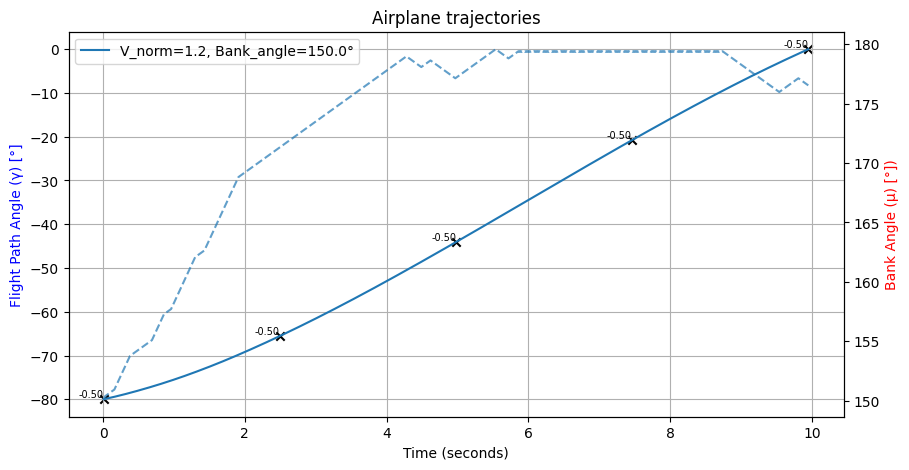

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from utils.utils import get_optimal_action



# generate a list of random initial states allowing for a wide range of values
np.random.seed(0)
initial_states = np.random.rand(5, 3)
initial_states[:, 0] = initial_states[:, 0] * np.deg2rad(90) - np.deg2rad(90)  # Flight path angle
initial_states[:, 1] = initial_states[:, 1] * 3.3 + 0.7  # Airspeed
initial_states[:, 2] = initial_states[:, 2] * np.deg2rad(230) - np.deg2rad(30)  # Bank angle

initial_states = [np.array([np.deg2rad(-80.),  1.2, np.deg2rad(150)])]  # Example state

#initial_states  = [np.array([np.deg2rad(-80.),  1.2, np.deg2rad(150)])]  # Example state
fig, ax1 = plt.subplots(figsize=(10, 5))  # Main figure

ax2 = ax1.twinx()  # Create secondary y-axis

# Loop through each initial state
for initial_state in initial_states:
    state = np.array(initial_state)  # Convert list to numpy array
    glider.airplane.flight_path_angle = state[0]
    glider.airplane.airspeed_norm = state[1]
    glider.airplane.bank_angle = state[2]

    # Storage for plotting
    flight_path_angles = []
    time_steps = []
    cl_values = []
    height_lost_values = []

    total_height_lost = 0
    episode_length = 0
    terminated = False

    # Run simulation
    while episode_length < 150:

        if not terminated:
            try:
                action = get_optimal_action(state, pi)
                #action[0] = 1.0
                state, reward, terminated, _, _ = glider.step(action)
                state = state[0]
            except:
                terminated = True
            

        total_height_lost += reward # Update height lost
        episode_length += 0.01

        # Convert to readable format
        flight_path_angle = float(np.rad2deg(state[0]))
        V_norm = float(state[1])
        bank_angle = float(np.rad2deg(state[2]))
        C_L = float(action[0])  # Extract lift coefficient

        # Store values
        flight_path_angles.append(flight_path_angle)
        time_steps.append(episode_length)
        cl_values.append(C_L)
        height_lost_values.append(float(np.rad2deg(state[2])))

        print(f"Action: {np.round(action,3)} | Reward: {total_height_lost} | \
                State: {flight_path_angle, V_norm, bank_angle} | Terminated: {terminated} |\
                Episode Length: {episode_length} | C_L: {C_L}")

        if terminated:
            break

    # Plot the flight path angle on primary axis
    ax1.plot(time_steps, flight_path_angles,label=f"V_norm={round(initial_state[1],2)}, Bank_angle={round(np.rad2deg(initial_state[2]),1)}°") 
    # Plot height lost on secondary axis
    ax2.plot(time_steps, height_lost_values, linestyle="dashed", alpha=0.7)

    # Select 5 evenly spaced indices for C_L annotations
    num_points = 5
    if len(time_steps) > num_points:
        indices = np.linspace(0, len(time_steps) - 1, num_points, dtype=int)
    else:
        indices = range(len(time_steps))  # If fewer than 5 points exist

    # Plot markers and add annotations for C_L
    for i in indices:
        ax1.scatter(time_steps[i], flight_path_angles[i], color="black", marker="x")  # Mark point
        ax1.text(time_steps[i], flight_path_angles[i], f"{cl_values[i]:.2f}", fontsize=7, 
                 verticalalignment='bottom', 
                 horizontalalignment='right')

# Graph settings
ax1.set_xlabel("Time (seconds)")
ax1.set_ylabel("Flight Path Angle (γ) [°]", color="blue")
ax2.set_ylabel("Bank Angle (μ) [°])", color="red")
ax1.set_title("Airplane trajectories")
ax1.legend()
ax1.grid()

plt.show()


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from utils.utils import get_optimal_action


vel_norm = 1.2  # Airspeed (V) in normalized units
# Example discretization
flight_path_bins = np.linspace(np.deg2rad(-90), np.deg2rad(0),    40,      dtype=np.float32) 
bank_bins        = np.linspace( np.deg2rad(-30), np.deg2rad(200), 40,      dtype=np.float32) 


# Prepare a 2D array to store the policy (CL values)
policy_values = np.zeros((len(flight_path_bins), len(bank_bins)))

# Fill in the 2D array by evaluating your policy at each (γ, μ)
for i, mu_rad in enumerate(bank_bins):
    for j, gamma_rad in enumerate(flight_path_bins):
        # Convert angles to radians if your policy needs it
        state = np.array([gamma_rad,  vel_norm, mu_rad])
        action = get_optimal_action(state, pi)  # Replace with your actual policy call
        cl = float(action[0])  # If the first element of `action` is the lift coefficient
        policy_values[i, j] = cl
        #print(f"State: {float(np.rad2deg(state)[0]), vel_norm ,float(np.rad2deg(state)[2]) } | CL: {cl}")

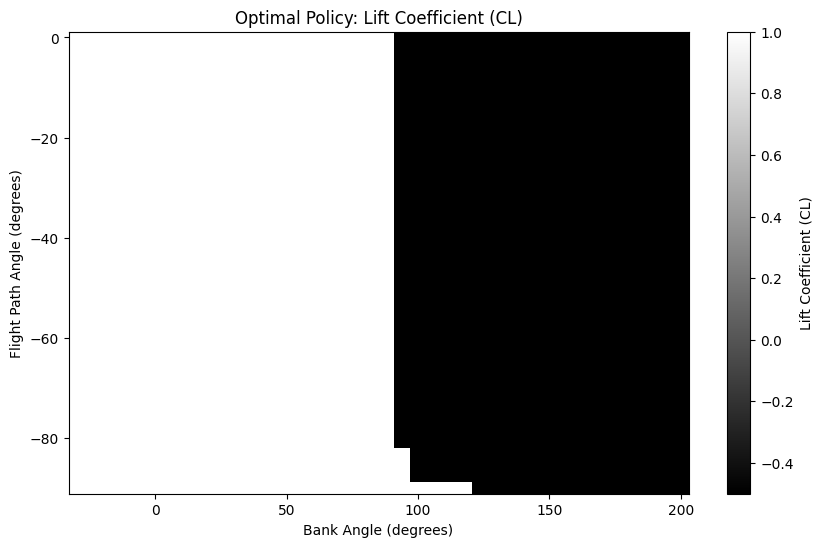

In [4]:
# Calculate edges (as before)
gamma_centers = flight_path_bins
gamma_step = gamma_centers[1] - gamma_centers[0]
gamma_edges = np.linspace(gamma_centers[0] - gamma_step/2, gamma_centers[-1] + gamma_step/2, len(gamma_centers)+1)
gamma_edges_deg = np.rad2deg(gamma_edges)

mu_centers = bank_bins
mu_step = mu_centers[1] - mu_centers[0]
mu_edges = np.linspace(mu_centers[0] - mu_step/2, mu_centers[-1] + mu_step/2, len(mu_centers)+1)
mu_edges_deg = np.rad2deg(mu_edges)

# Plot with inverted axes (swap x and y)
plt.figure(figsize=(10, 6))
plt.pcolormesh(
    mu_edges_deg,  # Now x-axis (bank angles)
    gamma_edges_deg,  # Now y-axis (flight path angles)
    policy_values.T,  # Transpose the array to align with swapped axes
    cmap='gray',
    shading='flat'
)
plt.xlabel('Bank Angle (degrees)')  # Updated label
plt.ylabel('Flight Path Angle (degrees)')  # Updated label
cbar = plt.colorbar(label='Lift Coefficient (CL)')
plt.title('Optimal Policy: Lift Coefficient (CL)')
plt.show()

In [5]:
state = np.array([np.deg2rad(-80.),  1.2, np.deg2rad(150)])  # Example state
get_optimal_action(state, pi)[0]  # Replace with your actual policy call

np.float32(-0.5)

In [ ]:
# Normalize the policy values (0 to 1) for grayscale plotting
vmin, vmax = policy_values.min(), policy_values.max()
norm_values = (policy_values - vmin) / (vmax - vmin + 1e-8)

# Create a mesh for plotting
X, Y = np.meshgrid(bank_angles, flight_path_angles)

# Plot using pcolormesh (grayscale)
fig, ax = plt.subplots(figsize=(6, 4))
c = ax.pcolormesh(X, Y, norm_values, cmap='gray', shading='auto', norm=mcolors.Normalize(vmin=0, vmax=1))

# Labels and title
ax.set_xlabel("Bank Angle (deg)")
ax.set_ylabel("Flight Path Angle (deg)")
ax.set_title("Optimal Policy (CL)")

# Optional: colorbar
plt.colorbar(c, ax=ax, label="Normalized CL")

plt.show()


In [ ]:
-192769.51 + -125086.89

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from utils.utils import get_optimal_action

# initial state
state = np.array([np.deg2rad(-60), 1.2, np.deg2rad(30)])
glider.airplane.flight_path_angle = state[0]
glider.airplane.airspeed_norm     = state[1]
glider.airplane.bank_angle        = state[2]

total_height_lost = 0
episode_length    = 0
terminated        = False

time_history = []
height_lost_history = []

while episode_length < 20:
    action = get_optimal_action(state, pi)
    prev_state = state.copy()
    state, reward, terminated, _, _ = glider.step(action)
    state = state[0] 
    total_height_lost += reward
    episode_length += 0.01

    time_history.append(episode_length)  # for plotting!
    height_lost_history.append(total_height_lost)

    #print(f"Action: {np.round(action,3)} | Lost Height: {total_height_lost:.3f} | State: {state} | Terminated: {terminated} | Time: {episode_length:.2f}")
    if terminated:
        break

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(time_history, height_lost_history, label="Height Lost")
plt.xlabel("Time (s)")
plt.ylabel("Height Lost (m)")
plt.title("Height Lost Over Time")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
STALL_AIRSPEED = 27.331231856346
from utils.utils import get_optimal_action
from tqdm import tqdm
with open(glider.__class__.__name__ + ".pkl", "rb") as f:
    pi: PolicyIteration = pickle.load(f)

prom_episode_lenght = 0
dict_result = {}
dict_episode_length = {}
state_spaces = [v for v in pi.states_space if v[0] > -np.pi/2]
for state in tqdm(state_spaces):
    initial_state = state.copy()
    prev_state = state.copy()
    glider.reset()
    glider.airplane.flight_path_angle = state[0]
    glider.airplane.airspeed_norm = state[1]
    glider.airplane.bank_angle = state[2]
    done = False
    episode_length = 0
    total_reward = 0
    while not done:
        action = get_optimal_action(state, pi)
        prev_state  = state.copy()
        state, reward, done, _, _ = glider.step(action)
        done  = bool(done)
        if done:
            break
        state = state[0]
        # check if our state is in the state space
        index = pi.triangulation.find_simplex(state)
        if not done:
            total_reward -= reward#*STALL_AIRSPEED
        if (index ==-1) or episode_length > 70: 
            done = True
        episode_length += 1
        
    dict_result[tuple(initial_state)] = total_reward
    dict_episode_length[tuple(initial_state)] = episode_length
    prom_episode_lenght += episode_length / len(pi.states_space)
    #print(f"Initial state: {initial_state} - Total reward: {total_reward}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
epsilon = 1*1e-1
#dict_result = dict_episode_length
# Your dictionary with keys as coordinates (x, y) and values as the color intensity (z)
# Extracting the x, y and z values
x = [np.degrees(coord[0]) for coord in dict_result.keys() if 0.05 >= coord[0] >= -np.pi/2 - epsilon and coord[1] > 0.7]
#convert x to grad
y = [coord[1] for coord in dict_result.keys() if 0.05 >= coord[0] >= -np.pi/2 - epsilon and coord[1] > 0.7]
#convert y to Vs
keys_list = list(dict_result.keys())
values_list = list(dict_result.values())
z = [v for e,v in zip(keys_list, values_list) if 0.05 >= e[0] >= -np.pi/2 - epsilon and e[1] > 0.7]

# Creating a 2D scatter plot
cmap = plt.get_cmap('viridis', 2048)
plt.tricontourf(y, x, z, cmap=cmap, levels=18)   # Change 'viridis' to any other colormap you like
plt.colorbar(label='', shrink=0.8,  )  # Add color bar for the z values

# Add labels and a title
plt.ylabel('Flight Path Angle (γ) [deg]')
plt.xlabel('V/Vs')

x_min, x_max = min(x), max(x)
y_min, y_max = min(y), max(y)

# Set the minor ticks for the grid, keeping the dense grid with smaller squares
ax = plt.gca()  # Get current axes
ax.set_yticks(np.linspace(x_min, x_max, 60), minor=True)  # 20 minor ticks for grid
ax.set_xticks(np.linspace(y_min, y_max, 60), minor=True)  # 20 minor ticks for grid
# put line x = 1
plt.axvline(x=1, color='r', linestyle='--', linewidth=0.5)
# put line y = 0
#plt.axhline(y=0, color='k', linestyle='--')

# Show the plot
vals = np.round(np.linspace(-90, 0,6))
plt.yticks(vals)  # Only 5 labels on x-axis
plt.xticks(np.linspace(round(y_min), round(y_max), 6))  # Only 5 labels on y-axis
# Enable the minor grid lines
ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)

# Habilitar la cuadrícula en las marcas menores
ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)

# Guardar la imagen sin borde blanco
plt.savefig('output.png', bbox_inches='tight')

# set size of the plot
plt.gcf().set_size_inches(9, 5)

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Your dictionary with keys as coordinates (x, y) and values as the color intensity (z)
# Extracting the x, y and z values
x = [np.degrees(coord[0]) for coord in dict_result.keys() if 5 >= coord[0] >= -np.pi/2 and coord[1] > 0.7]
y = [coord[1] for coord in dict_result.keys() if 5 >= coord[0] >= -np.pi/2 and coord[1] > 0.7]
keys_list = list(dict_result.keys())
values_list = list(dict_result.values())
z = [v for e,v in zip(keys_list, values_list) if 5 >= e[0] >= -np.pi/2 and e[1] > 0.7]

# Create a grid for interpolation
x_grid = np.linspace(min(x), max(x), 100)
y_grid = np.linspace(min(y), max(y), 100)
X, Y = np.meshgrid(x_grid, y_grid)

# Interpolate the scattered data into the grid
Z = griddata((y, x), z, (Y, X), method='linear')

# Create the scatter plot
cmap = plt.get_cmap('viridis', 2048)
plt.scatter(y, x, c=z, cmap=cmap)

# Add color bar
plt.colorbar(label='', shrink=0.8)
contour_levels = np.linspace(np.min(z), np.max(z), 10)  # 10 levels
contour_levels = contour_levels[contour_levels != 0]    # Remove zero from levels

# Add contour lines on top of the scatter plot
contour = plt.contour(Y, X, Z, levels=contour_levels, colors='black', linewidths=0.75)
plt.clabel(contour, inline=True, fontsize=8)  # Optional: add labels to the contours

# Add labels and a title
plt.ylabel('Flight Path Angle (γ) [deg]')
plt.xlabel('V/Vs')

# Plot vertical line at x=1
plt.axvline(x=1, color='k', linestyle='--')

# Configure the minor ticks and grid
x_min, x_max = min(x), max(x)
y_min, y_max = min(y), max(y)
ax = plt.gca()  # Get current axes
ax.set_yticks(np.linspace(x_min, x_max, 60), minor=True)
ax.set_xticks(np.linspace(y_min, y_max, 60), minor=True)
plt.yticks(np.linspace(x_min, x_max, 6))  # Major ticks on y-axis
plt.xticks(np.linspace(y_min, y_max, 4))  # Major ticks on x-axis

# Set size of the plot
plt.gcf().set_size_inches(9, 5)

# Enable the minor grid lines
ax.grid(which='minor', color='white', linestyle='-', linewidth=0.25)

# Habilitar la cuadrícula en las marcas menores
ax.grid(which='minor', color='white', linestyle='-', linewidth=0.25)

# Save the image
plt.savefig('output_with_contours.png', bbox_inches='tight')

# Show the plot
plt.show()


# CartPoleEnv 

### Observation Space

The observation is a `ndarray` with shape `(4,)` with the values corresponding to the following positions and velocities:

| Num | Observation           | Min                 | Max               |
|-----|-----------------------|---------------------|-------------------|
| 0   | Cart Position         | -4.8                | 4.8               |
| 1   | Cart Velocity         | -Inf                | Inf               |
| 2   | Pole Angle            | ~ -0.418 rad (-24°) | ~ 0.418 rad (24°) |
| 3   | Pole Angular Velocity | -Inf                | Inf               |

### Action Space

The action is a `ndarray` with shape `(1,)` which can take values `{0, 1}` indicating the direction
of the fixed force the cart is pushed with.

- 0: Push cart to the left
- 1: Push cart to the right

In [ ]:
# Train cartpole environment:
from classic_control.cartpole import CartPoleEnv
# CartPole environment:
env = CartPoleEnv(sutton_barto_reward=True)
# position thresholds:
x_lim         = 2.4
theta_lim     = 0.418 
# velocity thresholds:
x_dot_lim     = 3.1
theta_dot_lim = 3.1

bins_space = {
    "x_space"         : np.linspace(-x_lim, x_lim, 10,  dtype=np.float32),                     # position space          (0)
    "x_dot_space"     : np.linspace(-x_dot_lim, x_dot_lim, 10,  dtype=np.float32),             # velocity space          (1)
    "theta_space"     : np.linspace(-theta_lim, theta_lim, 10, dtype=np.float32),              # angle space             (2)
    "theta_dot_space" : np.linspace(-theta_dot_lim, theta_dot_lim, 10, dtype=np.float32),      # angular velocity space  (3)
}

pi = PolicyIteration(
    env=env, 
    bins_space=bins_space,
    action_space=np.array([0, 1], dtype=np.int32),
    gamma=0.99,
    theta=1e-3
)

pi.run()

In [ ]:
# Test cartpole environment:

with open(env.__class__.__name__ + ".pkl", "rb") as f:
    pi = pickle.load(f)

test_enviroment(CartPoleEnv(sutton_barto_reward=True, render_mode="human"), pi)

## Observation Space

The observation is a `ndarray` with shape `(2,)` where the elements correspond to the following:

| Num | Observation                          | Min   | Max  | Unit         |
|-----|--------------------------------------|-------|------|--------------|
| 0   | position of the car along the x-axis | -1.2  | 0.6  | position (m) |
| 1   | velocity of the car                  | -0.07 | 0.07 | velocity (v) |

## Action Space

There are 3 discrete deterministic actions:

- 0: Accelerate to the left
- 1: Don't accelerate
- 2: Accelerate to the right


In [ ]:
from classic_control.continuous_mountain_car import Continuous_MountainCarEnv

env=Continuous_MountainCarEnv()

bins_space = {
    "x_space":     np.linspace(env.min_position, env.max_position, 100,      dtype=np.float32),    # position space    (0)
    "x_dot_space": np.linspace(-abs(env.max_speed), abs(env.max_speed), 100, dtype=np.float32),    # velocity space    (1)
}

pi = PolicyIteration(
    env=env, 
    bins_space=bins_space,
    action_space=np.linspace(-1.0, +1.0, 9, dtype=np.float32),
    gamma=0.99,
    theta=1e-3,
)
pi.run()

In [ ]:
# Test mountain car environment:
with open(env.__class__.__name__ + ".pkl", "rb") as f:
    pi: PolicyIteration = pickle.load(f)

test_enviroment(Continuous_MountainCarEnv(render_mode="human"), pi)